# Statistical Data Analysis #

This notebook aims to complete the following tasks:
* Compute mean length of reviews for each star rating, and compute whether the differences in the means are statistically significant.
* Identify some number of frequent words across each star rating, calculate their frequency for each star rating, compare the differences of frequency across star ratings, and compute whether the differences in frequency are statistically significant.

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [13]:
# Import data as DataFrame
reviews = pd.read_csv('/Users/dwalkerpage/Documents/Data_Science/Springboard/Projects/springboard/Capstone_Projects/Capstone_Project_1/Capstone_Project_1_Data/restaurant_reviews_final.csv')

## 1. Analysis of Differences in Mean Review Length for Each Star Rating ##

### 1.1 Preparing the Data, Initial Analysis ###

In [14]:
# Construct series of review lengths (measured in terms of number of characters in review)
review_lens = reviews['text'].str.len()

In [15]:
# Construct new DataFrame with review lengths added as a column
review_lens_df = reviews.copy()
review_lens_df['review_lengths'] = review_lens
#review_lens_df.head()

In [16]:
review_lens_df.head()

,business_id,stars,text,review_lengths
0,EXAbfr5PkoRzMqlCb_3ALQ,5.0,We were in town from San Francisco to visit fr...,823
1,6sOBPz69VLgIvNAY7dowOg,2.0,I bought a Dealfind voucher and decided to giv...,534
2,VMXl3Dm1Nwvgwo1PVYTXbg,5.0,Fun club!! Great place to hang out and a real...,124
3,yNPh5SO-7wr8HPpVCDPbXQ,5.0,After our horrible customer service next door ...,353
4,L0aSDVHNXCl6sY4cfZQ-5Q,1.0,"If I could give this place zero stars, I would...",499


In [37]:
# Isolating review lengths by star ratings
one_star_lens = review_lens_df['review_lengths'][review_lens_df['stars'] == 1.0]
two_star_lens = review_lens_df['review_lengths'][review_lens_df['stars'] == 2.0]
three_star_lens = review_lens_df['review_lengths'][review_lens_df['stars'] == 3.0]
four_star_lens = review_lens_df['review_lengths'][review_lens_df['stars'] == 4.0]
five_star_lens = review_lens_df['review_lengths'][review_lens_df['stars'] == 5.0]

In [29]:
# Compute mean length of reviews for each star rating
len_stats = review_lens_df.groupby('stars').agg([np.mean])
len_stats

,review_lengths
,mean
stars,
1.0,669.122246
2.0,734.363719
3.0,701.818360
4.0,615.932487
5.0,469.145701


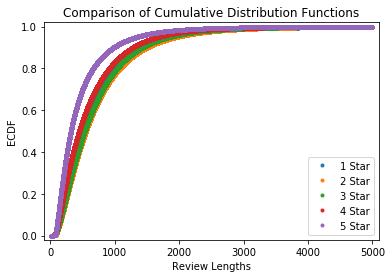

In [18]:
# Plot empirical cumulative distribution functions of review lengths for each star rating
# The ECDF indicates the distributions of the review lengths for each star rating,
# and how these distributions relate to each other
x1 = np.sort(review_lens_df[review_lens_df['stars'] == 1.0]['review_lengths'])
x2 = np.sort(review_lens_df[review_lens_df['stars'] == 2.0]['review_lengths'])
x3 = np.sort(review_lens_df[review_lens_df['stars'] == 3.0]['review_lengths'])
x4 = np.sort(review_lens_df[review_lens_df['stars'] == 4.0]['review_lengths'])
x5 = np.sort(review_lens_df[review_lens_df['stars'] == 5.0]['review_lengths'])
y1 = np.arange(1, len(x1)+1) / len(x1)
y2 = np.arange(1, len(x2)+1) / len(x2)
y3 = np.arange(1, len(x3)+1) / len(x3)
y4 = np.arange(1, len(x4)+1) / len(x4)
y5 = np.arange(1, len(x5)+1) / len(x5)

_ = plt.plot(x1, y1, marker='.', linestyle='none', label='1 Star')
_ = plt.plot(x2, y2, marker='.', linestyle='none', label='2 Star')
_ = plt.plot(x3, y3, marker='.', linestyle='none', label='3 Star')
_ = plt.plot(x4, y4, marker='.', linestyle='none', label='4 Star')
_ = plt.plot(x5, y5, marker='.', linestyle='none', label='5 Star')
_ = plt.xlabel('Review Lengths')
_ = plt.ylabel('ECDF')
_ = plt.title('Comparison of Cumulative Distribution Functions')
plt.margins(0.02)
plt.legend(loc='lower right')
plt.show()

In [35]:
# Data table grouped by star rating categories that includes
# the total number of non-missing observations, standard deviation, standard error, and the 95% confidence interval.
rp.summary_cont(review_lens_df['review_lengths'].groupby(review_lens_df['stars']))

,N,Mean,SD,SE,95% Conf.,Interval
stars,,,,,,
1.0,481143,669.122246,618.003496,0.890951,667.375981,670.868512
2.0,378515,734.363719,629.447069,1.023099,732.358442,736.368995
3.0,538961,701.818360,592.841645,0.807533,700.235595,703.401125
4.0,1054999,615.932487,550.122738,0.535591,614.882728,616.982247
5.0,1589831,469.145701,465.203214,0.368950,468.422559,469.868843


### 1.2 ANOVA - One Way (Analysis of Variance) ###
See [here](https://pythonfordatascience.org/anova-python/) for helpful tutorial.  
For practice, we will conduct the ANOVA test in two different ways.

**Null Hypothesis:** The mean review lengths are the same for each star rating.  
**Alternative Hypothesis:** The mean review lengths are *not* the same for each star rating. That is, at least one of the mean review lengths differs from another.

**alpha:** We will set alpha at 0.05, and thus conclude that a p-value less than or equal to 0.05 is statistically significant.

In [39]:
# Taking samples to make groups same size
one_star_lens_sample = one_star_lens.sample(n=1000, random_state=7)
two_star_lens_sample = two_star_lens.sample(n=1000, random_state=7)
three_star_lens_sample = three_star_lens.sample(n=1000, random_state=7)
four_star_lens_sample = four_star_lens.sample(n=1000, random_state=7)
five_star_lens_sample = five_star_lens.sample(n=1000, random_state=7)

In [41]:
# First ANOVA test with scipy.stats
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html
stats.f_oneway(one_star_lens_sample, two_star_lens_sample, three_star_lens_sample, four_star_lens_sample, five_star_lens_sample)

F_onewayResult(statistic=36.22489614861847, pvalue=6.869670691699495e-30)

In [65]:
# Prepare samples for second ANOVA test with statsmodels

# Construct DataFrame from samples
review_samples = pd.DataFrame({'1_star': one_star_lens_sample,
                               '2_star': two_star_lens_sample,
                               '3_star': three_star_lens_sample,
                               '4_star': four_star_lens_sample,
                               '5_star': five_star_lens_sample}).reset_index(drop=True)

# Remove NaN values from DataFrame
review_samples = review_samples.apply(lambda x: pd.Series(x.dropna().values))

# Reshape DataFrame for ANOVA test
review_samples = review_samples.melt(var_name='stars', value_name='review_lengths')

#review_samples.head()

In [66]:
# Second ANOVA test with statsmodels
# https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html
results = ols('review_lengths ~ C(stars)', data=review_samples).fit()

In [67]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         review_lengths   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     36.22
Date:                Sat, 14 Dec 2019   Prob (F-statistic):           6.87e-30
Time:                        14:34:04   Log-Likelihood:                -38763.
No. Observations:                5000   AIC:                         7.754e+04
Df Residuals:                    4995   BIC:                         7.757e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            668.3140     17.819     37.506      0.000     633.381     703.247
C(stars)[T.2_star]    73.0420     25.200      2.898      0.004      23.639     122.445
C(stars)[T.3_star]    38.4720     25.200      1.527      0.127     -10.931      87.875
C(stars)[T.4_star]   -60.1290     25.200     -2.386      0.017    -109.532     -10.726
C(stars)[T.5_star]  -199.9850     25.200     -7.936      0.000    -249.388    -150.582
==============================================================================
Omnibus:                     2697.551   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23286.482
Skew:                           2.454   Prob(JB):                         0.00
Kurtosis:                      12.364   Cond. No.                         5.83
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
aov_table = sm.stats.anova_lm(results, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(stars),4.600833e+07,4.0,36.224896,6.869671e-30
Residual,1.586006e+09,4995.0,NaN,NaN


Both ways of doing the ANOVA test (with scipy.stats and statsmodels) show that the $F$-statistic=36.224 and the p-value approximates 0, which indicates that the observed differences in review lengths for the star ratings are statistically significant. The $F$-statistic is a ratio of the variation *between* the variables divided by the variation *within* the variables, so a large value indicates that more of the variation is explained by variation between the variables than by variation within the variables. We can conclude that there is an overall statistically significant effect of star rating on review length. However, the ANOVA test leaves open where the effect occurs, or where the statistically significant difference is located. We can now conduct a post-hoc analysis by using t-tests between pairs of star ratings to answer this further question of which specific differences are statistically significant.

For discussion of F-tests, and interpreting the results, see [here](https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/f-statistic-value-test/) and [here](https://www.statisticshowto.datasciencecentral.com/mean-square-between/).

### 1.3 Post Hoc Analysis ###

In our post hoc analysis, we will conduct t-tests on the following 6 pairs of star ratings: 1 & 4, 1 & 5, 2 & 4, 2 & 5,3 & 4, 3 & 5. We select these 6 pairs because in our modeling we will consider ratings of 1, 2, or 3 to indicate negative sentiment, and 4 or 5 to indicate positive sentiment. Since the primary goal is to discriminate between reviews manifesting negative or positive sentiment, the main comparisons that matter are between star ratings in the negative sentiment group (1, 2, or 3) and star ratings in the positive sentiment group (4 or 5).  

In conducting our post hoc analysis we need to control for familywise error. We will use the Bonferroni correction of dividing our significance level for the ANOVA by the number of t-tests we plan to run, and using the new value as our significance level for the t-tests.

In [74]:
# Calculate new significance level (original alpha / number of t-tests)
new_alpha = round(0.05/6, 4)
new_alpha

0.0083

In [84]:
# Define function to perform t-tests
def t_test(data1, data2):
    result = stats.ttest_ind(data1, data2)
    if result[1] <= new_alpha:
        print(result)
        print('The difference is statistically significant.')
    else:
        print(result)
        print('The difference is not statistically significant.')

In [85]:
# Comparison of 1 & 4 Star Reviews
t_test(one_star_lens_sample, four_star_lens_sample)

Ttest_indResult(statistic=2.4186073389717624, pvalue=0.01566890993003886)
The difference is not statistically significant.


In [86]:
# Comparison of 1 & 5 Star Reviews
t_test(one_star_lens_sample, five_star_lens_sample)

Ttest_indResult(statistic=8.628699769853972, pvalue=1.2434223398955543e-17)
The difference is statistically significant.


In [88]:
# Comparison of 2 & 4 Star Reviews
t_test(two_star_lens_sample, four_star_lens_sample)

Ttest_indResult(statistic=5.029314469543813, pvalue=5.362169525825639e-07)
The difference is statistically significant.


In [89]:
# Comparison of 2 & 5 Star Reviews
t_test(two_star_lens_sample, five_star_lens_sample)

Ttest_indResult(statistic=10.9630272765738, pvalue=3.368668155131326e-27)
The difference is statistically significant.


In [90]:
# Comparison of 3 & 4 Star Reviews
t_test(three_star_lens_sample, four_star_lens_sample)

Ttest_indResult(statistic=3.928125514479278, pvalue=8.851854364474471e-05)
The difference is statistically significant.


In [91]:
# Comparison of 3 & 5 Star Reviews
t_test(three_star_lens_sample, five_star_lens_sample)

Ttest_indResult(statistic=10.175561044966399, pvalue=9.56199857485892e-24)
The difference is statistically significant.


### 1.4 Conclusions ###

Our post hoc analysis indicates that (using the Bonferroni correction) five (of the six tested) differences in mean review lengths are statistically significant. In particular, the differences in mean review lengths between 1 and 5 stars, 2 and 4 stars, 2 and 5, 3 and 4 stars, and 3 and 5 stars are statistically significant.  

This analysis suggests that we may be able to use the length of a review to help classify it as manifesting positive or negative sentiment.

## 2. Analysis of Differences in Word Frequency for Each Star Rating ##

Suggestions for calculating word frequencies:
* https://stackoverflow.com/questions/46786211/counting-the-frequency-of-words-in-a-pandas-data-frame
* https://www.geeksforgeeks.org/find-frequency-of-each-word-in-a-string-in-python/
* https://www.datacamp.com/community/tutorials/absolute-weighted-word-frequency
* https://programminghistorian.org/en/lessons/counting-frequencies
* *Think Python*, Ch. 13